# Clairvoyante


In [1]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import time
import numpy as np
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import clairvoyante
import clairvoyante.utils_v2 as utils
import clairvoyante.clairvoyante_v2 as cv
import clairvoyante.param as param

## Load a trained model for Illumina sequencing data

In [3]:
# Load a trained model into memory
m = cv.Clairvoyante()
m.init()
m.restoreParameters("../trainedModels/illumina2/full_round4-less17-031351")

INFO:tensorflow:Restoring parameters from ../trainedModels/illumina2/full_round4-less17-031351


INFO:tensorflow:Restoring parameters from ../trainedModels/illumina2/full_round4-less17-031351


In [4]:
# Show the number of parameters of the model
r = tf.train.NewCheckpointReader("../trainedModels/illumina2/full_round4-less17-031351")
p = r.get_variable_to_shape_map()
tot = 0
for k, v in sorted(p.items(), key=lambda x: x[0]):
    if 'Momentum' not in k and\
       'global_step' not in k and\
       'Adam' not in k and\
       'power' not in k:
        tmp = np.prod(v)
        tot += tmp
        print >> sys.stderr, '%s: %s => %d' % (k, str(v), tmp)
print >> sys.stderr, 'Total number of parameters: %d' % tot

YBaseChangeSigmoid/bias: [4] => 4
YBaseChangeSigmoid/kernel: [168, 4] => 672
YIndelLengthFC/bias: [6] => 6
YIndelLengthFC/kernel: [168, 6] => 1008
YVarTypeFC/bias: [4] => 4
YVarTypeFC/kernel: [168, 4] => 672
YZygosityFC/bias: [2] => 2
YZygosityFC/kernel: [168, 2] => 336
conv1/bias: [16] => 16
conv1/kernel: [1, 4, 4, 16] => 256
conv2/bias: [32] => 32
conv2/kernel: [2, 4, 16, 32] => 4096
conv3/bias: [48] => 48
conv3/kernel: [3, 4, 32, 48] => 18432
fc4/bias: [336] => 336
fc4/kernel: [4608, 336] => 1548288
fc5/bias: [168] => 168
fc5/kernel: [336, 168] => 56448
Total number of parameters: 1630824


In [5]:
r = tf.train.NewCheckpointReader("../trainedModels/slim_illumina2/slim_round1-less22-021625")
p = r.get_variable_to_shape_map()
tot = 0
for k, v in sorted(p.items(), key=lambda x: x[0]):
    if 'Momentum' not in k and\
       'global_step' not in k and\
       'Adam' not in k and\
       'power' not in k:
        tmp = np.prod(v)
        tot += tmp
        print >> sys.stderr, '%s: %s => %d' % (k, str(v), tmp)
print >> sys.stderr, 'Total number of parameters: %d' % tot

YBaseChangeSigmoid/bias: [4] => 4
YBaseChangeSigmoid/kernel: [18, 4] => 72
YIndelLengthFC/bias: [6] => 6
YIndelLengthFC/kernel: [18, 6] => 108
YVarTypeFC/bias: [4] => 4
YVarTypeFC/kernel: [18, 4] => 72
YZygosityFC/bias: [2] => 2
YZygosityFC/kernel: [18, 2] => 36
conv1/bias: [8] => 8
conv1/kernel: [1, 4, 4, 8] => 128
conv2/bias: [16] => 16
conv2/kernel: [3, 4, 8, 16] => 1536
conv3/bias: [32] => 32
conv3/kernel: [5, 4, 16, 32] => 10240
fc4/bias: [36] => 36
fc4/kernel: [4224, 36] => 152064
fc5/bias: [18] => 18
fc5/kernel: [36, 18] => 648
Total number of parameters: 165030


In [6]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("../training/tensor_can_chr22",
                       "../training/var_chr22",
                       "../training/bed",
                       shuffle = False)

In [7]:
# Pick a random candidate
i = 0
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

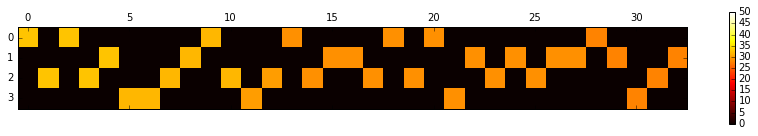

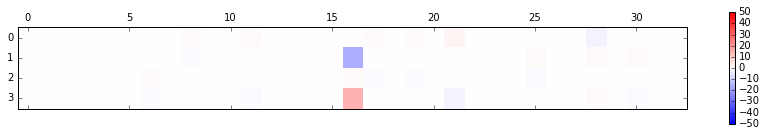

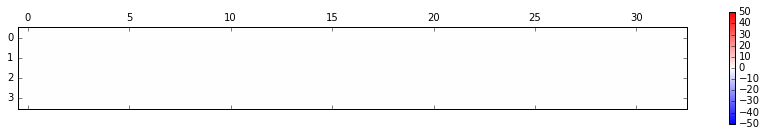

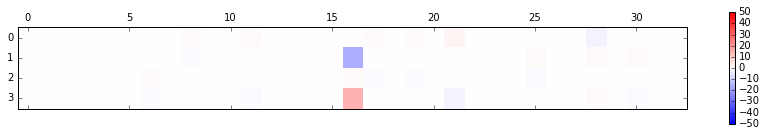

In [8]:
# Show how the four matrices are like
figure(figsize=(15, 2)); matshow(XArray[0,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.hot, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,3].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()

## Testing on the variants

In [12]:
print >> sys.stderr, "Testing on the training and validation dataset ..."
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print >> sys.stderr, "Prediciton time elapsed: %.2f s" % (time.time() - predictStart)

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print >> sys.stderr, "Version 2 model, evaluation on base change:"
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print >> sys.stderr, "all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100)
print >> sys.stderr, "Version 2 model, evaluation on Zygosity:"
ed = np.zeros( (2,2), dtype=np.int )
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(2)])
print >> sys.stderr, "Version 2 model, evaluation on variant type:"
ed = np.zeros( (4,4), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(4)])
print >> sys.stderr, "Version 2 model, evaluation on indel length:"
ed = np.zeros( (6,6), dtype=np.int )
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(6)])

Testing on the training and validation dataset ...
Prediciton time elapsed: 21.84 s
Version 2 model, evaluation on base change:
all/top1/top2/top1p/top2p: 69760/57817/69748/82.88/99.98
Version 2 model, evaluation on Zygosity:
23901	11
116	45732
Version 2 model, evaluation on variant type:
35104	117	2	2
6	34434	1	0
1	3	68	0
0	0	0	22
Version 2 model, evaluation on indel length:
69660	4	0	0	0	2
2	52	0	0	0	0
4	0	13	0	0	0
1	1	0	5	0	0
1	0	0	0	4	0
0	0	0	0	0	11


## Visualizing predictions

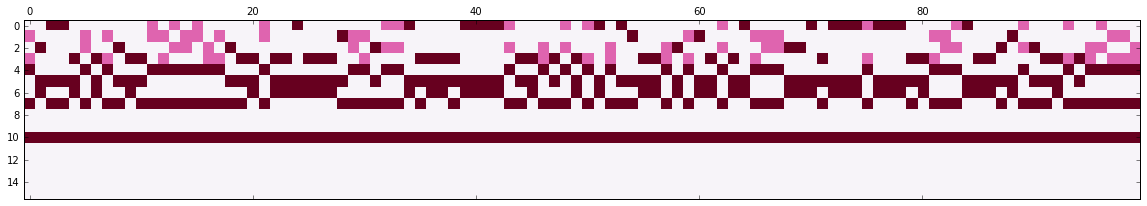

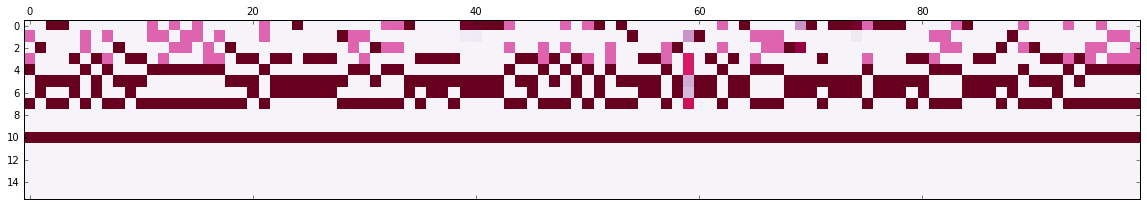

In [14]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],zs[arrayStart:arrayEnd,:],\
                         ts[arrayStart:arrayEnd,:],ls[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)